# 1. Gender Classification Using Recurrent Neural Network (RNN)

---



## 1.1 Necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Dense, SimpleRNN, Flatten
from tensorflow.keras import layers
import os
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.layers import TimeDistributed

## 1.2 Download the dataset

In [2]:
import requests
url = "https://data.brasil.io/dataset/genero-nomes/nomes.csv.gz"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

df = pd.read_csv('nomes.csv.gz') 
df.head()

,alternative_names,classification,first_name,frequency_female,frequency_male,frequency_total,frequency_group,group_name,ratio
0,AILINE|ALEINE|ALIINE|ALINE|ALINER|ALINHE|ALINN...,F,AALINE,66.0,NaN,66,530550,ALINE,1.0
1,ARAAO|ARAO,M,AARAO,NaN,281.0,281,3526,ARAO,1.0
2,AHARON|AROM|ARON|ARYON|HARON,M,AARON,NaN,676.0,676,3442,ARON,1.0
3,ADA|ADAH|ADAR|ADHA|HADA,F,ABA,82.0,NaN,82,5583,ADA,1.0
4,NaN,M,ABADE,NaN,57.0,57,57,ABADE,1.0


### 1.2.1 Preparing the data 

In [3]:
y = df['classification'].astype("category").cat.codes.values # y labels into numbers
names = df['first_name'].apply(lambda x: x.lower()) # input names

## 1.3 Encoding Words

In [4]:
maxlen = 20
vocab = set(' '.join([str(i) for i in names]))
vocab.add('END')
len_vocab = len(vocab)
char_index = dict((c, i) for i, c in enumerate(vocab))

In [5]:
x = []
# Builds an empty line with a 1 at the index of character
def set_flag(i):
    tmp = np.zeros(len_vocab);
    tmp[i] = 1
    return list(tmp)

# Truncate names and create the matrix
def prepare_encod_names(X):
    new_list = []
    trunc_train_name = [str(i)[0:maxlen] for i in X]

    for i in trunc_train_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        new_list.append(tmp)

    return new_list


x = prepare_encod_names(names.values)

## 1.4 Split the data into test and train

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=28)
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

## 1.5 Building the RNN Model

In [11]:
model=keras.Sequential()
model.add(SimpleRNN(32, input_shape=(x_train.shape[1],x_train.shape[2]), activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(1))) 
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()                                             # print the model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 20, 32)            1952      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 1)             33        
_________________________________________________________________
flatten_1 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 2,006
Trainable params: 2,006
Non-trainable params: 0
_________________________________________________________________


## 1.6 Fitting the data into model

In [12]:
history=model.fit(x_train, y_train , epochs=10, batch_size=128, validation_data=(x_test,y_test))
scores = model.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
630/630 [==============================] - 6s 7ms/step - loss: 0.3291 - accuracy: 0.8459 - val_loss: 0.2201 - val_accuracy: 0.9119
Epoch 2/10
630/630 [==============================] - 4s 7ms/step - loss: 0.2059 - accuracy: 0.9173 - val_loss: 0.1813 - val_accuracy: 0.9287
Epoch 3/10
630/630 [==============================] - 4s 7ms/step - loss: 0.1872 - accuracy: 0.9269 - val_loss: 0.1849 - val_accuracy: 0.9294
Epoch 4/10
630/630 [==============================] - 4s 7ms/step - loss: 0.1769 - accuracy: 0.9306 - val_loss: 0.1747 - val_accuracy: 0.9307
Epoch 5/10
630/630 [==============================] - 4s 7ms/step - loss: 0.1669 - accuracy: 0.9347 - val_loss: 0.1748 - val_accuracy: 0.9332
Epoch 6/10
630/630 [==============================] - 4s 7ms/step - loss: 0.1689 - accuracy: 0.9344 - val_loss: 0.1675 - val_accuracy: 0.9352
Epoch 7/10
630/630 [==============================] - 4s 7ms/step - loss: 0.1630 - accuracy: 0.9371 - val_loss: 0.1682 - val_accuracy: 0.9333
Epoch 

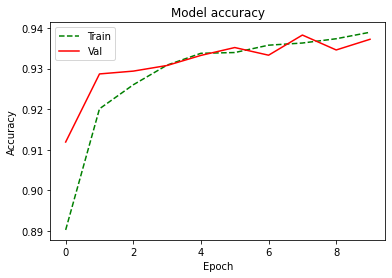

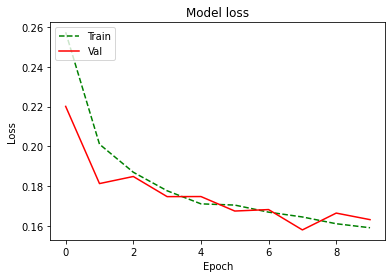

In [13]:
# summarize history for accuracy
plt.plot(history.history['accuracy'], 'g--')
plt.plot(history.history['val_accuracy'], 'r')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'], 'g--')
plt.plot(history.history['val_loss'], 'r')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

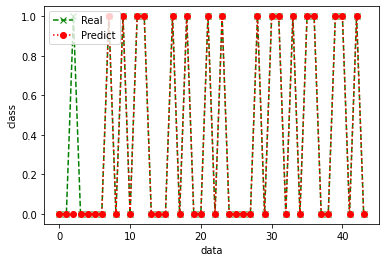

In [14]:
y_pred =(model.predict(x_test) > 0.5).astype("int32")
plt.figure(2)
plt.plot(y_test[6:50], 'g--x')
plt.plot(y_pred[6:50], 'r:o')
plt.ylabel('class')
plt.xlabel('data')
plt.legend(['Real', 'Predict'], loc='upper left')
plt.show()